In [143]:
# imports
import pandas as pd
import numpy as np

# Viz imports
import matplotlib.pyplot as plt
import seaborn as sns

# Config matplotlib
%matplotlib inline
plt.rcParams["patch.force_edgecolor"] = True # in matplotlib, edge borders are turned off by default.
sns.set_style("darkgrid") # set a grey grid as a background

# turn off warnings
import warnings
warnings.filterwarnings('ignore')

# tensorflow and sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# importing models and layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout
from tensorflow.keras.callbacks import EarlyStopping

# metrics
from sklearn.metrics import classification_report, confusion_matrix

In [2]:
df = pd.read_csv('TensorFlow_FILES/DATA/lending_club_loan_two.csv')
df_info=pd.read_csv('TensorFlow_FILES/DATA/lending_club_info.csv')

In [3]:
pd.options.display.max_colwidth = 250
df_info

,LoanStatNew,Description
0,loan_amnt,"The listed amount of the loan applied for by the borrower. If at some point in time, the credit department reduces the loan amount, then it will be reflected in this value."
1,term,The number of payments on the loan. Values are in months and can be either 36 or 60.
2,int_rate,Interest Rate on the loan
3,installment,The monthly payment owed by the borrower if the loan originates.
4,grade,LC assigned loan grade
5,sub_grade,LC assigned loan subgrade
6,emp_title,The job title supplied by the Borrower when applying for the loan.*
7,emp_length,Employment length in years. Possible values are between 0 and 10 where 0 means less than one year and 10 means ten or more years.
8,home_ownership,"The home ownership status provided by the borrower during registration or obtained from the credit report. Our values are: RENT, OWN, MORTGAGE, OTHER"
9,annual_inc,The self-reported annual income provided by the borrower during registration.


In [4]:
def lookup(x):
    ''' 
    return a description of the variable
    '''
    return df_info[df_info['LoanStatNew']== x]

In [5]:
lookup('application_type')

,LoanStatNew,Description
25,application_type,Indicates whether the loan is an individual application or a joint application with two co-borrowers


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 396030 entries, 0 to 396029
Data columns (total 27 columns):
loan_amnt               396030 non-null float64
term                    396030 non-null object
int_rate                396030 non-null float64
installment             396030 non-null float64
grade                   396030 non-null object
sub_grade               396030 non-null object
emp_title               373103 non-null object
emp_length              377729 non-null object
home_ownership          396030 non-null object
annual_inc              396030 non-null float64
verification_status     396030 non-null object
issue_d                 396030 non-null object
loan_status             396030 non-null object
purpose                 396030 non-null object
title                   394275 non-null object
dti                     396030 non-null float64
earliest_cr_line        396030 non-null object
open_acc                396030 non-null float64
pub_rec                 396030 non-nu

In [7]:
df.revol_bal.dtype

dtype('float64')

In [8]:
df.head(3)

,loan_amnt,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,...,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,application_type,mort_acc,pub_rec_bankruptcies,address
0,10000.0,36 months,11.44,329.48,B,B4,Marketing,10+ years,RENT,117000.0,...,16.0,0.0,36369.0,41.8,25.0,w,INDIVIDUAL,0.0,0.0,"0174 Michelle Gateway\nMendozaberg, OK 22690"
1,8000.0,36 months,11.99,265.68,B,B5,Credit analyst,4 years,MORTGAGE,65000.0,...,17.0,0.0,20131.0,53.3,27.0,f,INDIVIDUAL,3.0,0.0,"1076 Carney Fort Apt. 347\nLoganmouth, SD 05113"
2,15600.0,36 months,10.49,506.97,B,B3,Statistician,< 1 year,RENT,43057.0,...,13.0,0.0,11987.0,92.2,26.0,f,INDIVIDUAL,0.0,0.0,"87025 Mark Dale Apt. 269\nNew Sabrina, WV 05113"


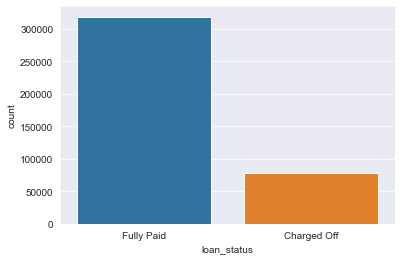

In [9]:
# this is more of an imbalanced problem - far fewer chargeoffs than Fully Paid
# accuracy will be better, but will tune to precision and recall
sns.countplot(df.loan_status)

In [10]:
df[df.loan_amnt > 0]['loan_amnt'][:10]

0    10000.0
1     8000.0
2    15600.0
3     7200.0
4    24375.0
5    20000.0
6    18000.0
7    13000.0
8    18900.0
9    26300.0
Name: loan_amnt, dtype: float64

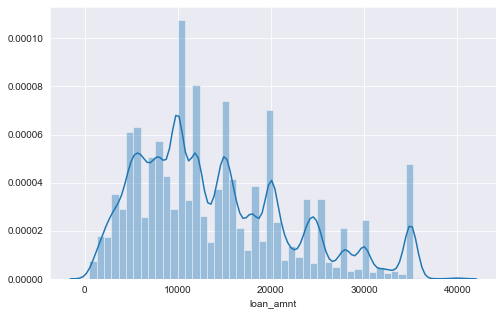

In [11]:
plt.figure(figsize=(8,5))
sns.distplot(df[df.loan_amnt > 0]['loan_amnt'])

#### checking out the correlation of continuous variables

In [12]:
df.corr()

,loan_amnt,int_rate,installment,annual_inc,dti,open_acc,pub_rec,revol_bal,revol_util,total_acc,mort_acc,pub_rec_bankruptcies
loan_amnt,1.000000,0.168921,0.953929,0.336887,0.016636,0.198556,-0.077779,0.328320,0.099911,0.223886,0.222315,-0.106539
int_rate,0.168921,1.000000,0.162758,-0.056771,0.079038,0.011649,0.060986,-0.011280,0.293659,-0.036404,-0.082583,0.057450
installment,0.953929,0.162758,1.000000,0.330381,0.015786,0.188973,-0.067892,0.316455,0.123915,0.202430,0.193694,-0.098628
annual_inc,0.336887,-0.056771,0.330381,1.000000,-0.081685,0.136150,-0.013720,0.299773,0.027871,0.193023,0.236320,-0.050162
dti,0.016636,0.079038,0.015786,-0.081685,1.000000,0.136181,-0.017639,0.063571,0.088375,0.102128,-0.025439,-0.014558
open_acc,0.198556,0.011649,0.188973,0.136150,0.136181,1.000000,-0.018392,0.221192,-0.131420,0.680728,0.109205,-0.027732
pub_rec,-0.077779,0.060986,-0.067892,-0.013720,-0.017639,-0.018392,1.000000,-0.101664,-0.075910,0.019723,0.011552,0.699408
revol_bal,0.328320,-0.011280,0.316455,0.299773,0.063571,0.221192,-0.101664,1.000000,0.226346,0.191616,0.194925,-0.124532
revol_util,0.099911,0.293659,0.123915,0.027871,0.088375,-0.131420,-0.075910,0.226346,1.000000,-0.104273,0.007514,-0.086751
total_acc,0.223886,-0.036404,0.202430,0.193023,0.102128,0.680728,0.019723,0.191616,-0.104273,1.000000,0.381072,0.042035


Notice that loan_amnt and installment are almost perfectly correlated, which is an indicator that it's not a feature, just some correlated duplicate data. This can leak data and skew the model. 


In [13]:
lookup('installment')

,LoanStatNew,Description
3,installment,The monthly payment owed by the borrower if the loan originates.


In [14]:
lookup('loan_amnt')

,LoanStatNew,Description
0,loan_amnt,"The listed amount of the loan applied for by the borrower. If at some point in time, the credit department reduces the loan amount, then it will be reflected in this value."


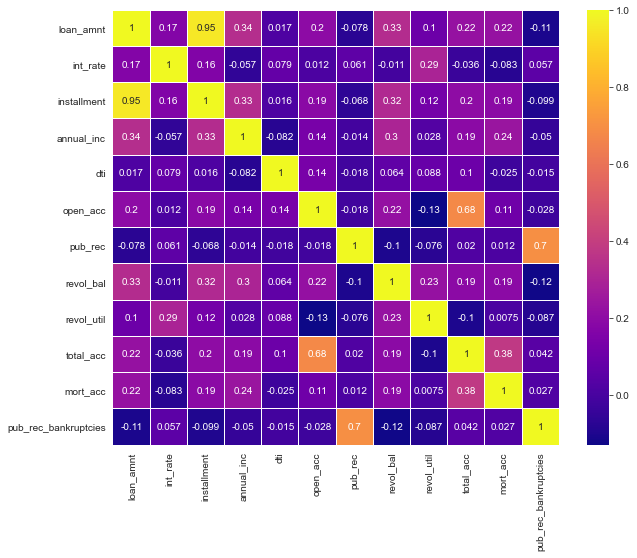

In [15]:
plt.figure(figsize=(10,8))
sns.heatmap(df.corr(),linewidths=.01,cmap='plasma',annot=True)

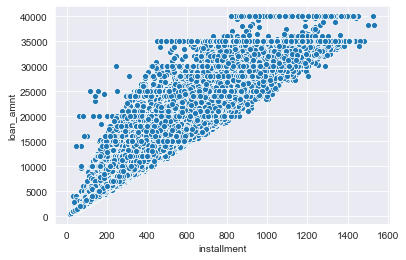

In [16]:
# can we confirm that installment and loan_amnt are correlated?
sns.scatterplot(x='installment',y='loan_amnt',data=df)

#### Is there a relationship between high loan amounts and defaulting?

They're very similar, but we can say that the averages of loan amount for defaulting are slightly higher than the averages for fully paid off loans

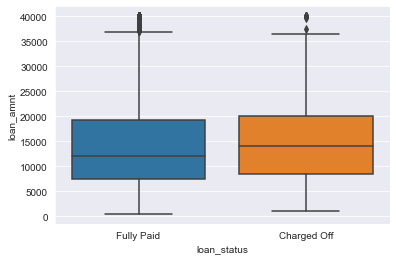

In [17]:
# make a boxplot comparing the loan_status to the loan_amount
sns.boxplot(x='loan_status',y='loan_amnt',data=df)

In [18]:
# break out the statistics for just these features
df.groupby('loan_status')['loan_amnt'].describe()

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
Charged Off,77673.0,15126.300967,8505.090557,1000.0,8525.0,14000.0,20000.0,40000.0
Fully Paid,318357.0,13866.878771,8302.319699,500.0,7500.0,12000.0,19225.0,40000.0


#### check out categoricals like grade to see if they would be easy to dummy

In [19]:
df.grade.unique()

array(['B', 'A', 'C', 'E', 'D', 'F', 'G'], dtype=object)

In [20]:
df.grade.value_counts()

B    116018
C    105987
A     64187
D     63524
E     31488
F     11772
G      3054
Name: grade, dtype: int64

In [21]:
df.sub_grade.unique()

array(['B4', 'B5', 'B3', 'A2', 'C5', 'C3', 'A1', 'B2', 'C1', 'A5', 'E4',
       'A4', 'A3', 'D1', 'C2', 'B1', 'D3', 'D5', 'D2', 'E1', 'E2', 'E5',
       'F4', 'E3', 'D4', 'G1', 'F5', 'G2', 'C4', 'F1', 'F3', 'G5', 'G4',
       'F2', 'G3'], dtype=object)

In [22]:
grade_order = sorted(df['grade'].unique())
grade_order

['A', 'B', 'C', 'D', 'E', 'F', 'G']

In [23]:
%pprint

Pretty printing has been turned OFF


In [24]:
subgrade_order = sorted(df['sub_grade'].unique())
subgrade_order

['A1', 'A2', 'A3', 'A4', 'A5', 'B1', 'B2', 'B3', 'B4', 'B5', 'C1', 'C2', 'C3', 'C4', 'C5', 'D1', 'D2', 'D3', 'D4', 'D5', 'E1', 'E2', 'E3', 'E4', 'E5', 'F1', 'F2', 'F3', 'F4', 'F5', 'G1', 'G2', 'G3', 'G4', 'G5']

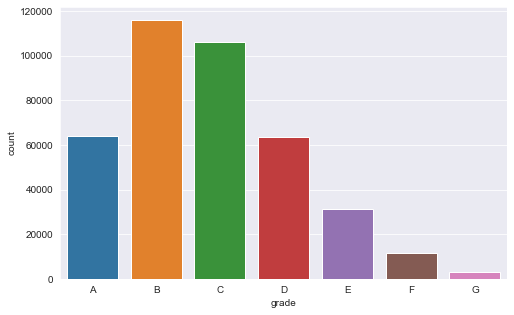

In [25]:
plt.figure(figsize=(8,5))
#sns.countplot(df[df.grade != 0]['grade'])
sns.countplot(df.grade,order=grade_order)

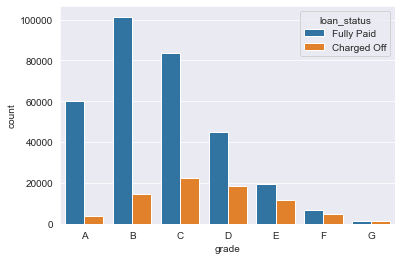

In [26]:
sns.countplot(x='grade',data=df,hue='loan_status',order=grade_order)

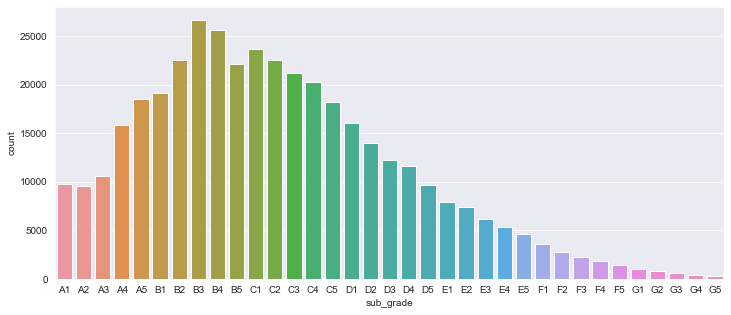

In [27]:
plt.figure(figsize=(12,5))
sns.countplot(df.sub_grade,order=subgrade_order)

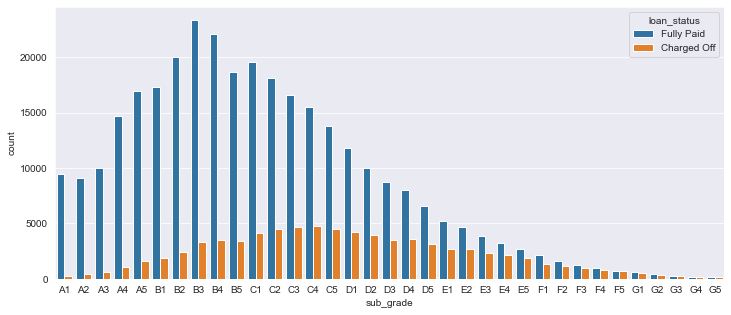

In [28]:
plt.figure(figsize=(12,5))
sns.countplot(x='sub_grade',data=df,hue='loan_status',order=subgrade_order)

Focusing in on F and G that have high default rates 

In [29]:
# Get the last 10 values which should encompass G and F and make a list
gorf = subgrade_order[-10:]

In [30]:
# create a new dataframe that only contains grades F or G
dfgf = df[(df.grade == 'F') | (df.grade == 'G')]

In [31]:
dfgf[:3]

,loan_amnt,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,...,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,application_type,mort_acc,pub_rec_bankruptcies,address
66,15975.0,60 months,24.99,468.80,F,F4,carrier,5 years,MORTGAGE,47000.0,...,10.0,0.0,2049.0,58.5,23.0,w,INDIVIDUAL,1.0,0.0,"59681 Christopher Lock\nNorth Williamtown, UT 70466"
87,30000.0,60 months,24.70,875.28,G,G1,Medtronic,5 years,MORTGAGE,187321.0,...,21.0,0.0,54810.0,93.4,52.0,f,INDIVIDUAL,3.0,0.0,"25281 Kevin Neck\nArmstrongton, TN 29597"
96,12625.0,60 months,25.78,376.36,F,F5,Nursing Assistant,7 years,MORTGAGE,43000.0,...,18.0,0.0,19993.0,55.7,31.0,w,INDIVIDUAL,1.0,0.0,"522 Melissa Village\nEast Janice, MT 00813"


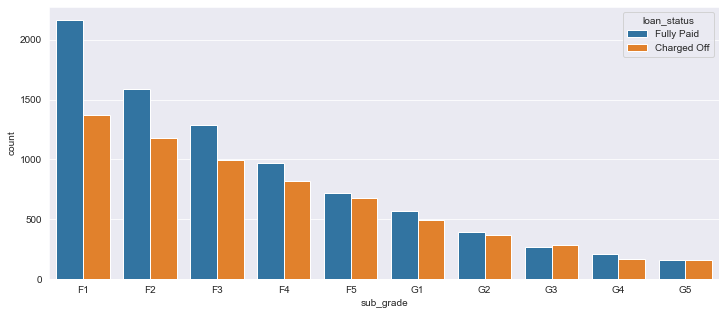

In [32]:
# use the new dfgf and the gorf list
plt.figure(figsize=(12,5))
sns.countplot(x='sub_grade',data=dfgf,hue='loan_status',order=gorf)


### making a correlation map between default and other continuous features

Add  new feature 'loan_repaid' - 1 if paid, 0 if defaulted - classification needs a boolean represented by binary

In [33]:
df.loan_status.unique()

array(['Fully Paid', 'Charged Off'], dtype=object)

In [34]:
#mapping style
df.loan_status.map({'Fully Paid':1,'Charged Off':0})[:3]

0    1
1    1
2    1
Name: loan_status, dtype: int64

In [35]:
# lambda style
df['loan_repaid'] = df.loan_status.apply(lambda x: 1 if x == 'Fully Paid' else 0)

In [36]:
df.loan_repaid[:3]

0    1
1    1
2    1
Name: loan_repaid, dtype: int64

In [37]:
# check the mapping
df[['loan_repaid','loan_status']][:10]

,loan_repaid,loan_status
0,1,Fully Paid
1,1,Fully Paid
2,1,Fully Paid
3,1,Fully Paid
4,0,Charged Off
5,1,Fully Paid
6,1,Fully Paid
7,1,Fully Paid
8,1,Fully Paid
9,1,Fully Paid


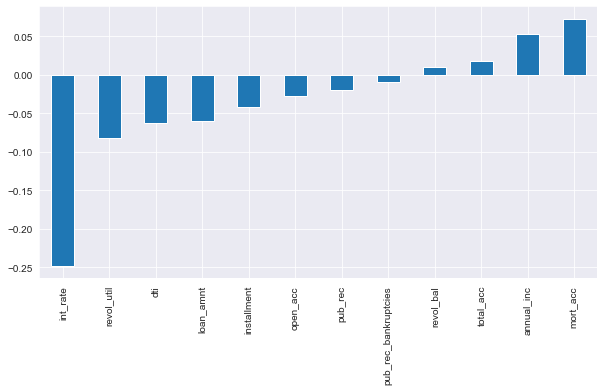

In [38]:
plt.figure(figsize=(10,5))
df.corr()['loan_repaid'][:-1].sort_values().plot(kind='bar') # -1 chops off the loan_repaid to loan_repaid correlation

### Data cleaning

Working with missing data.

- Keep it
- Drop it
- Fill it in

In [39]:
# 396030 entries - a number with missing data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 396030 entries, 0 to 396029
Data columns (total 28 columns):
loan_amnt               396030 non-null float64
term                    396030 non-null object
int_rate                396030 non-null float64
installment             396030 non-null float64
grade                   396030 non-null object
sub_grade               396030 non-null object
emp_title               373103 non-null object
emp_length              377729 non-null object
home_ownership          396030 non-null object
annual_inc              396030 non-null float64
verification_status     396030 non-null object
issue_d                 396030 non-null object
loan_status             396030 non-null object
purpose                 396030 non-null object
title                   394275 non-null object
dti                     396030 non-null float64
earliest_cr_line        396030 non-null object
open_acc                396030 non-null float64
pub_rec                 396030 non-nu

In [40]:
# lots of nulls
df.isnull().sum()

loan_amnt                   0
term                        0
int_rate                    0
installment                 0
grade                       0
sub_grade                   0
emp_title               22927
emp_length              18301
home_ownership              0
annual_inc                  0
verification_status         0
issue_d                     0
loan_status                 0
purpose                     0
title                    1755
dti                         0
earliest_cr_line            0
open_acc                    0
pub_rec                     0
revol_bal                   0
revol_util                276
total_acc                   0
initial_list_status         0
application_type            0
mort_acc                37795
pub_rec_bankruptcies      535
address                     0
loan_repaid                 0
dtype: int64

#### get percentage of missing data types

Can't drop between 4 and 9% of the total data  
mort_acc                9.543469  
emp_title               5.789208  
emp_length              4.621115  

but these could be cheaply removed  
title                   0.443148  
pub_rec_bankruptcies    0.135091  
revol_util              0.069692  

In [41]:
# make a dataframe of the percentage
miss = 100 * df.isnull().sum() / len(df)

In [42]:
# show only features with missing values
miss.sort_values(ascending=False)[:6]

mort_acc                9.543469
emp_title               5.789208
emp_length              4.621115
title                   0.443148
pub_rec_bankruptcies    0.135091
revol_util              0.069692
dtype: float64

In [43]:
lookup('emp_length')

,LoanStatNew,Description
7,emp_length,Employment length in years. Possible values are between 0 and 10 where 0 means less than one year and 10 means ten or more years.


In [44]:
lookup('emp_title')

,LoanStatNew,Description
6,emp_title,The job title supplied by the Borrower when applying for the loan.*


In [45]:
lookup('title')

,LoanStatNew,Description
14,title,The loan title provided by the borrower


In [46]:
df.columns

Index(['loan_amnt', 'term', 'int_rate', 'installment', 'grade', 'sub_grade',
       'emp_title', 'emp_length', 'home_ownership', 'annual_inc',
       'verification_status', 'issue_d', 'loan_status', 'purpose', 'title',
       'dti', 'earliest_cr_line', 'open_acc', 'pub_rec', 'revol_bal',
       'revol_util', 'total_acc', 'initial_list_status', 'application_type',
       'mort_acc', 'pub_rec_bankruptcies', 'address', 'loan_repaid'],
      dtype='object')

In [47]:
sorted(df.emp_length.dropna().unique())

['1 year', '10+ years', '2 years', '3 years', '4 years', '5 years', '6 years', '7 years', '8 years', '9 years', '< 1 year']

In [48]:
emp_length_order = ['< 1 year','1 year', '2 years', '3 years', '4 years', '5 years', '6 years', '7 years', '8 years', '9 years','10+ years']

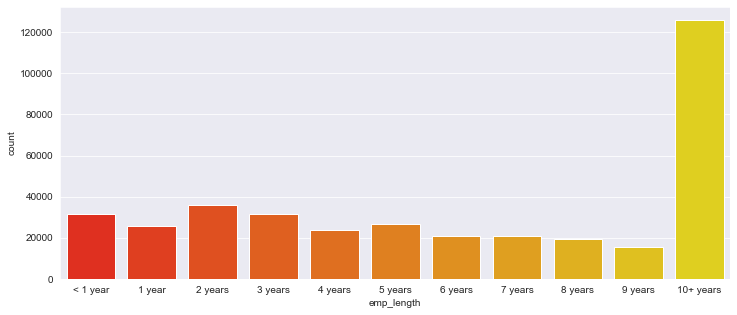

In [49]:
plt.figure(figsize=(12,5))
sns.countplot(x='emp_length',data=df,order=emp_length_order,palette='autumn')

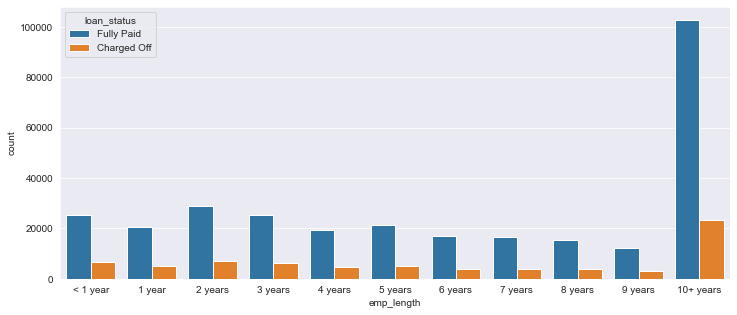

In [50]:
plt.figure(figsize=(12,5))
sns.countplot(x='emp_length',data=df,hue='loan_status',order=emp_length_order)

Now get percentage of chargeoffs to paid accounts per year of employement

create two dfs and extract the count of the emp_length to loan_status

In [51]:
df[df.loan_status == 'Charged Off'].groupby('emp_length').count()['loan_status']

emp_length
1 year        5154
10+ years    23215
2 years       6924
3 years       6182
4 years       4608
5 years       5092
6 years       3943
7 years       4055
8 years       3829
9 years       3070
< 1 year      6563
Name: loan_status, dtype: int64

In [52]:
emp_defaulted = df[df.loan_status == 'Charged Off'].groupby('emp_length').count()['loan_status']

In [53]:
df[df.loan_status == 'Fully Paid'].groupby('emp_length').count()['loan_status']

emp_length
1 year        20728
10+ years    102826
2 years       28903
3 years       25483
4 years       19344
5 years       21403
6 years       16898
7 years       16764
8 years       15339
9 years       12244
< 1 year      25162
Name: loan_status, dtype: int64

In [54]:
emp_paid = df[df.loan_status == 'Fully Paid'].groupby('emp_length').count()['loan_status']

#### Divide defaulted by paid to get the percentages

In [55]:
# direct ratio
emp_defaulted / emp_paid

emp_length
1 year       0.248649
10+ years    0.225770
2 years      0.239560
3 years      0.242593
4 years      0.238213
5 years      0.237911
6 years      0.233341
7 years      0.241887
8 years      0.249625
9 years      0.250735
< 1 year     0.260830
Name: loan_status, dtype: float64

In [56]:
#percent per category
100 * emp_defaulted / (emp_defaulted + emp_paid)

emp_length
1 year       19.913453
10+ years    18.418610
2 years      19.326206
3 years      19.523133
4 years      19.238477
5 years      19.218721
6 years      18.919438
7 years      19.477400
8 years      19.976002
9 years      20.047016
< 1 year     20.687155
Name: loan_status, dtype: float64

In [57]:

defaulted_emp_ratio = emp_defaulted / emp_paid

In [58]:
defaulted_emp_percent =  100 * emp_defaulted / (emp_defaulted + emp_paid)

The big takeaway is that none of these show big swings in years of employment to defaulting, so not a very strong metric. This is ok to drop.

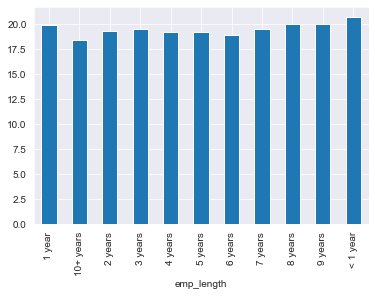

In [59]:
defaulted_emp_percent.plot(kind='bar')

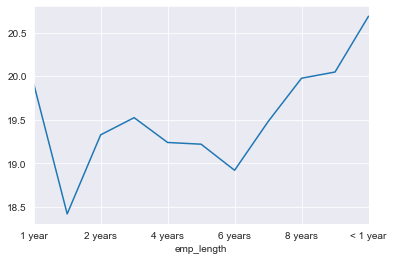

In [60]:
# need to fix the <1, 1, 10 years to so that this shows a sensible line
defaulted_emp_percent.plot()

In [61]:
df.isnull().sum()

loan_amnt                   0
term                        0
int_rate                    0
installment                 0
grade                       0
sub_grade                   0
emp_title               22927
emp_length              18301
home_ownership              0
annual_inc                  0
verification_status         0
issue_d                     0
loan_status                 0
purpose                     0
title                    1755
dti                         0
earliest_cr_line            0
open_acc                    0
pub_rec                     0
revol_bal                   0
revol_util                276
total_acc                   0
initial_list_status         0
application_type            0
mort_acc                37795
pub_rec_bankruptcies      535
address                     0
loan_repaid                 0
dtype: int64

In [62]:
df = df.drop(['emp_length'],axis=1)

What's left?


In [63]:
miss.sort_values(ascending=False)[:6]

mort_acc                9.543469
emp_title               5.789208
emp_length              4.621115
title                   0.443148
pub_rec_bankruptcies    0.135091
revol_util              0.069692
dtype: float64

In [64]:
# drop title (this was dropped in this run, uncomment for new run)
# df = df.drop(['emp_title'],axis=1)

In [65]:
# title is also not helpful, so just drop it
df = df.drop(['title'],axis=1)

In [66]:
miss2 = 100 * df.isnull().sum() / len(df)

In [67]:
miss2.sort_values(ascending=False)[:6]

mort_acc                9.543469
emp_title               5.789208
pub_rec_bankruptcies    0.135091
revol_util              0.069692
loan_repaid             0.000000
issue_d                 0.000000
dtype: float64

#### dealing with mort_acc - too big to drop and must fill in data extrapolating from other columns

- almost 10% of accounts are missing values. 
- Drop the feature? - only missing %10
- How to fill in the data (mean, mode?)

Can we find something that correlates highly with mort_acc that can be used as a proxy?




In [68]:
lookup('mort_acc')

,LoanStatNew,Description
26,mort_acc,Number of mortgage accounts.


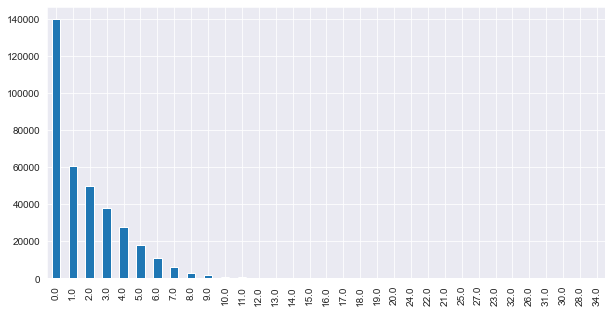

In [69]:
plt.figure(figsize=(10,5))
df.mort_acc.value_counts().plot(kind='bar')

In [70]:
# total_acc has some positive correlation (not duplicate data)
df.corr()['mort_acc'].sort_values(ascending=False)

mort_acc                1.000000
total_acc               0.381072
annual_inc              0.236320
loan_amnt               0.222315
revol_bal               0.194925
installment             0.193694
open_acc                0.109205
loan_repaid             0.073111
pub_rec_bankruptcies    0.027239
pub_rec                 0.011552
revol_util              0.007514
dti                    -0.025439
int_rate               -0.082583
Name: mort_acc, dtype: float64

In [71]:
# ok - this is a little twisted. group the df by total_acc, get the mort_acc values and find their mean
# then use that for fillna()
df.groupby('total_acc')['mort_acc'].mean()[:10]

total_acc
2.0     0.000000
3.0     0.052023
4.0     0.066743
5.0     0.103289
6.0     0.151293
7.0     0.221695
8.0     0.308422
9.0     0.365499
10.0    0.429158
Name: mort_acc, dtype: float64

In [72]:
# loks like the same output regardless of how to stack the terms
df.groupby('total_acc').mean()['mort_acc'][:10]

total_acc
2.0     0.000000
3.0     0.052023
4.0     0.066743
5.0     0.103289
6.0     0.151293
7.0     0.221695
8.0     0.308422
9.0     0.365499
10.0    0.429158
Name: mort_acc, dtype: float64

In [73]:
total_account_avg = df.groupby('total_acc').mean()['mort_acc']

In [74]:
df.total_acc.iloc[0]

25.0

In [75]:
# do a lookup of the average in the table for the total_acc value of a particular row
total_account_avg[df.total_acc.iloc[0]]

1.9005057623745958

In [76]:
def fill_mort_acc(total_acc, mort_acc):
    if np.isnan(mort_acc):
        return total_account_avg[total_acc]
    else:
        return mort_acc
    

In [77]:
# a little convoluted, but use a lambda to apply the function.
df.mort_acc = df.apply(lambda x: fill_mort_acc(x['total_acc'],x['mort_acc']),axis=1)

In [78]:
df = df.drop('revol_util',axis=1)


In [79]:
df = df.drop('pub_rec_bankruptcies',axis=1)

In [80]:
# and that quashes that. Not to drop revol_utl and pub_rec_bankruptcies - they're small enough to not affect the outcome
df.isnull().sum()

loan_amnt                  0
term                       0
int_rate                   0
installment                0
grade                      0
sub_grade                  0
emp_title              22927
home_ownership             0
annual_inc                 0
verification_status        0
issue_d                    0
loan_status                0
purpose                    0
dti                        0
earliest_cr_line           0
open_acc                   0
pub_rec                    0
revol_bal                  0
total_acc                  0
initial_list_status        0
application_type           0
mort_acc                   0
address                    0
loan_repaid                0
dtype: int64

clear!

### Managing categorical data

In [81]:
# get a dataframe of only objects
df.select_dtypes(['object'])[:5]

,term,grade,sub_grade,emp_title,home_ownership,verification_status,issue_d,loan_status,purpose,earliest_cr_line,initial_list_status,application_type,address
0,36 months,B,B4,Marketing,RENT,Not Verified,Jan-2015,Fully Paid,vacation,Jun-1990,w,INDIVIDUAL,"0174 Michelle Gateway\nMendozaberg, OK 22690"
1,36 months,B,B5,Credit analyst,MORTGAGE,Not Verified,Jan-2015,Fully Paid,debt_consolidation,Jul-2004,f,INDIVIDUAL,"1076 Carney Fort Apt. 347\nLoganmouth, SD 05113"
2,36 months,B,B3,Statistician,RENT,Source Verified,Jan-2015,Fully Paid,credit_card,Aug-2007,f,INDIVIDUAL,"87025 Mark Dale Apt. 269\nNew Sabrina, WV 05113"
3,36 months,A,A2,Client Advocate,RENT,Not Verified,Nov-2014,Fully Paid,credit_card,Sep-2006,f,INDIVIDUAL,"823 Reid Ford\nDelacruzside, MA 00813"
4,60 months,C,C5,Destiny Management Inc.,MORTGAGE,Verified,Apr-2013,Charged Off,credit_card,Mar-1999,f,INDIVIDUAL,"679 Luna Roads\nGreggshire, VA 11650"


In [82]:
# get a list of columns with the Object datatype
df.select_dtypes(['object']).columns

Index(['term', 'grade', 'sub_grade', 'emp_title', 'home_ownership',
       'verification_status', 'issue_d', 'loan_status', 'purpose',
       'earliest_cr_line', 'initial_list_status', 'application_type',
       'address'],
      dtype='object')

#### dealing with Term

- pull out the integer (36 or 60) and change that in the dataframe
- one hot encode 36 months or not 36 months

There's an advantage to keeping the integer because there's a numeric  relationship

In [83]:
lookup('term')

,LoanStatNew,Description
1,term,The number of payments on the loan. Values are in months and can be either 36 or 60.


In [84]:
df.term.value_counts()

 36 months    302005
 60 months     94025
Name: term, dtype: int64

In [85]:
df.term = df.term.apply(lambda term: term[:3])

In [86]:
df.term = df.term.apply(int)

In [87]:
df.columns

Index(['loan_amnt', 'term', 'int_rate', 'installment', 'grade', 'sub_grade',
       'emp_title', 'home_ownership', 'annual_inc', 'verification_status',
       'issue_d', 'loan_status', 'purpose', 'dti', 'earliest_cr_line',
       'open_acc', 'pub_rec', 'revol_bal', 'total_acc', 'initial_list_status',
       'application_type', 'mort_acc', 'address', 'loan_repaid'],
      dtype='object')

#### grade

we know that grade is a part of sub-grade, so it can be dropped


In [88]:
df = df.drop('grade',axis=1)

In [100]:
df.columns

Index(['loan_amnt', 'term', 'int_rate', 'installment', 'sub_grade',
       'emp_title', 'home_ownership', 'annual_inc', 'verification_status',
       'issue_d', 'loan_status', 'purpose', 'dti', 'earliest_cr_line',
       'open_acc', 'pub_rec', 'revol_bal', 'total_acc', 'initial_list_status',
       'application_type', 'mort_acc', 'address', 'loan_repaid', 'zipcode'],
      dtype='object')

### using  dummies and drop_first
not duplicating information - want to change Categories to either numeric or boolean. 


when encoding M/F you don't want to end up with M and F, you want it to be a Male Boolean M 0 or 1

if A/B/C you don't want A, B and C columns - Boolean A or B and if not, then C



#### sub_grade

In [101]:
sub_grade_dummies = pd.get_dummies(df['sub_grade'],drop_first=True)
df  = pd.concat([df.drop('sub_grade',axis=1),sub_grade_dummies],axis=1)

In [102]:
# notice that A1 was dropped
df.columns

Index(['loan_amnt', 'term', 'int_rate', 'installment', 'emp_title',
       'home_ownership', 'annual_inc', 'verification_status', 'issue_d',
       'loan_status', 'purpose', 'dti', 'earliest_cr_line', 'open_acc',
       'pub_rec', 'revol_bal', 'total_acc', 'initial_list_status',
       'application_type', 'mort_acc', 'address', 'loan_repaid', 'zipcode',
       'A2', 'A3', 'A4', 'A5', 'B1', 'B2', 'B3', 'B4', 'B5', 'C1', 'C2', 'C3',
       'C4', 'C5', 'D1', 'D2', 'D3', 'D4', 'D5', 'E1', 'E2', 'E3', 'E4', 'E5',
       'F1', 'F2', 'F3', 'F4', 'F5', 'G1', 'G2', 'G3', 'G4', 'G5'],
      dtype='object')

#### adding verification_status, application_type, initial_list_status and purpose

In [ ]:
# Group all these dummies together
group_dummies = pd.get_dummies(df[['verification_status', 'application_type', 'initial_list_status','purpose']],drop_first=True)
df  = pd.concat([df.drop(['verification_status', 'application_type', 'initial_list_status','purpose'],axis=1),group_dummies],axis=1)

#### home_ownership


In [107]:
df.home_ownership.value_counts()

MORTGAGE    198348
RENT        159790
OWN          37746
OTHER          112
NONE            31
ANY              3
Name: home_ownership, dtype: int64

In [108]:
# consolidate ANY and NONE into OTHER
df.home_ownership = df.home_ownership.replace(['ANY','NONE'],'OTHER')

In [109]:
df.home_ownership.value_counts()

MORTGAGE    198348
RENT        159790
OWN          37746
OTHER          146
Name: home_ownership, dtype: int64

In [110]:
owner_dummies = pd.get_dummies(df['home_ownership'],drop_first=True)
df  = pd.concat([df.drop('home_ownership',axis=1),owner_dummies],axis=1)

#### address to zip code


In [111]:
df.address.iloc[0].split(' ')[-1]

'22690'

In [113]:
df.zipcode =  df.address.apply(lambda x: x.split()[-1])

In [115]:
# not that many - easy to make dummies
df.zipcode.value_counts()

70466    56985
30723    56546
22690    56527
48052    55917
00813    45824
29597    45471
05113    45402
11650    11226
93700    11151
86630    10981
Name: zipcode, dtype: int64

In [116]:
zipcode_dummies = pd.get_dummies(df['zipcode'],drop_first=True)
df  = pd.concat([df.drop('zipcode',axis=1),zipcode_dummies],axis=1)

In [117]:
df.head(3)

,loan_amnt,term,int_rate,installment,emp_title,annual_inc,issue_d,loan_status,dti,earliest_cr_line,...,RENT,05113,11650,22690,29597,30723,48052,70466,86630,93700
0,10000.0,36,11.44,329.48,Marketing,117000.0,Jan-2015,Fully Paid,26.24,Jun-1990,...,1,0,0,1,0,0,0,0,0,0
1,8000.0,36,11.99,265.68,Credit analyst,65000.0,Jan-2015,Fully Paid,22.05,Jul-2004,...,0,1,0,0,0,0,0,0,0,0
2,15600.0,36,10.49,506.97,Statistician,43057.0,Jan-2015,Fully Paid,12.79,Aug-2007,...,1,1,0,0,0,0,0,0,0,0


In [119]:
df = df.drop('address',axis=1)

#### issue_d

since the date the loan was issued wouldn't be something that could be predicted by the model, this is probably data leakage so it makes more sense to drop it

In [120]:
df = df.drop('issue_d',axis=1)

#### earliest_cr_line
extract the year as an integer and add a new feature called earliest_cr_year.

year won't need dummy variables because it can be treated as a continuous data type

In [124]:
df.earliest_cr_year = df.earliest_cr_line.apply(lambda date: date.split('-')[1]).apply(int)

In [126]:
df.earliest_cr_year[:3]

0    1990
1    2004
2    2007
Name: earliest_cr_line, dtype: int64

In [127]:
df = df.drop('earliest_cr_line',axis=1)

#### What's left for objects?


In [128]:
df.select_dtypes(['object']).columns

Index(['emp_title', 'loan_status'], dtype='object')

In [130]:
df = df.drop('emp_title',axis=1)

In [133]:
df = df.drop('loan_status',axis=1)

In [135]:
df.columns

Index(['loan_amnt', 'term', 'int_rate', 'installment', 'annual_inc', 'dti',
       'open_acc', 'pub_rec', 'revol_bal', 'total_acc', 'mort_acc',
       'loan_repaid', 'A2', 'A3', 'A4', 'A5', 'B1', 'B2', 'B3', 'B4', 'B5',
       'C1', 'C2', 'C3', 'C4', 'C5', 'D1', 'D2', 'D3', 'D4', 'D5', 'E1', 'E2',
       'E3', 'E4', 'E5', 'F1', 'F2', 'F3', 'F4', 'F5', 'G1', 'G2', 'G3', 'G4',
       'G5', 'Source Verified', 'Verified', 'INDIVIDUAL', 'JOINT', 'w',
       'credit_card', 'debt_consolidation', 'educational', 'home_improvement',
       'house', 'major_purchase', 'medical', 'moving', 'other',
       'renewable_energy', 'small_business', 'vacation', 'wedding', 'OTHER',
       'OWN', 'RENT', '05113', '11650', '22690', '29597', '30723', '48052',
       '70466', '86630', '93700'],
      dtype='object')

### Test/Train Split the data

In [146]:
# adding sampling example for larger data
# df = df.sample (frac=0.1,random_state=101)

In [137]:
X = df.drop('loan_repaid',axis=1).values
y = df['loan_repaid'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=101)

In [139]:
# scale the data
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [140]:
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

#### create the model

In [138]:
# match the columns row to the number of layers
X_train.shape

(297022, 75)

In [141]:
model = Sequential()
model.add(Dense(75,activation='relu'))
# configure the rate of drop: using 0 means no drop, 1 is all drops. Commonly .2 and .5.
model.add(Dropout(0.5)) # %50 probability of being dropped
model.add(Dense(37,activation='relu'))
model.add(Dropout(0.5)) # %50 probability of being dropped
model.add(Dense(1,activation='sigmoid')) # output neuron
# since this is binary the loss function is binary_crossentropy
model.compile(loss='binary_crossentropy',optimizer='adam')

In [144]:
early_stop = EarlyStopping(monitor='val_loss',mode='min',patience=25,verbose=0)

In [ ]:
# example using batch_size
# model.fit(x=X_train,y=y_train,epochs=200,validation_data=(X_test,y_test),verbose=1,
#         callbacks=[early_stop],batch_size=256)

In [145]:
model.fit(x=X_train,y=y_train,epochs=200,validation_data=(X_test,y_test),verbose=1,
         callbacks=[early_stop])

Epoch 1/200
9282/9282 [==============================] - 11s 1ms/step - loss: 0.2862 - val_loss: 0.2622
Epoch 2/200
9282/9282 [==============================] - 11s 1ms/step - loss: 0.2667 - val_loss: 0.2614
Epoch 3/200
9282/9282 [==============================] - 11s 1ms/step - loss: 0.2656 - val_loss: 0.2608
Epoch 4/200
9282/9282 [==============================] - 11s 1ms/step - loss: 0.2649 - val_loss: 0.2615
Epoch 5/200
9282/9282 [==============================] - 11s 1ms/step - loss: 0.2647 - val_loss: 0.2622
Epoch 6/200
9282/9282 [==============================] - 11s 1ms/step - loss: 0.2644 - val_loss: 0.2608
Epoch 7/200
9282/9282 [==============================] - 12s 1ms/step - loss: 0.2640 - val_loss: 0.2615
Epoch 8/200
9282/9282 [==============================] - 12s 1ms/step - loss: 0.2639 - val_loss: 0.2606
Epoch 9/200
9282/9282 [==============================] - 12s 1ms/step - loss: 0.2636 - val_loss: 0.2617
Epoch 10/200
9282/9282 [==============================] - 12s 1m

In [151]:
# save the model
model.save('lending_tree_model-v2.h5')

In [154]:
# to reload the model import 
# from tensorflow.keras.models import load_model
# from the help:
#
# >>> model = tf.keras.Sequential([
# ...     tf.keras.layers.Dense(5, input_shape=(3,)),
# ...     tf.keras.layers.Softmax()])
# >>> model.save('/tmp/model')
# >>> loaded_model = tf.keras.models.load_model('/tmp/model')
# >>> x = tf.random.uniform((10, 3))
# >>> assert np.allclose(model.predict(x), loaded_model.predict(x))

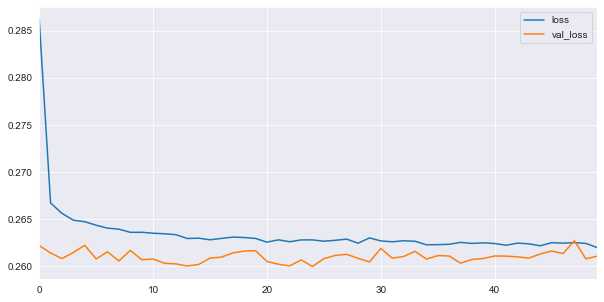

In [147]:
lossdf = pd.DataFrame(model.history.history)
lossdf.plot(figsize=(10,5))

In [148]:
predictions = model.predict_classes(X_test)

W0830 19:01:54.628937 4536980928 deprecation.py:323] From <ipython-input-148-bc83193b8b59>:1: Sequential.predict_classes (from tensorflow.python.keras.engine.sequential) is deprecated and will be removed after 2021-01-01.
Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


In [149]:
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       0.98      0.44      0.61     19365
           1       0.88      1.00      0.94     79643

   micro avg       0.89      0.89      0.89     99008
   macro avg       0.93      0.72      0.77     99008
weighted avg       0.90      0.89      0.87     99008



In [150]:
# shows that the network only misclassified one point in the test data
# True Negatives, False Positives
# False Negatives, True Positives
tn, fp, fn, tp = confusion_matrix(y_test,predictions).ravel()
print("Confusion Matrix")
print(confusion_matrix(y_test,predictions))
print('True Negatives',tn,'False Positives',fp,'False Negatives',fn,'True Positives',tp)

Confusion Matrix
[[ 8513 10852]
 [  148 79495]]
True Negatives 8513 False Positives 10852 False Negatives 148 True Positives 79495


### understanding the metrics in context of the original dataset

Note that from the original dataset 80% of the data was a repaid loan, so any loan_repaid prediction derived from that would be 80% accurate.

 This means that the floor of our expectation should be 80%, so the %89 f1-score from the micro-averages is good, but not fantastic. This is due to the imbalance in the dataset.
 
 
f1 score is the harmonic mean between precision and recall.

 
- defaults has good precision but bad recall
- repaids has decent precision and perfect recall
 
               precision    recall  f1-score   support

           0       0.98      0.44      0.61     19365 <-- defaults. Lower dataset Representation
           1       0.88      1.00      0.94     79643 <---repaids. Higher dataset Representation

So for this model the real metric that the model is doing well is the f1 score for the underrepresented class:  
defaults - 0 - f1: %61



The accuracy of the model is good on the whole. 
- random guess = 50% accuracy
- straight guess (the raw model accuracy) would be %80
- our accuracy is %89



In [155]:
df.loan_repaid.value_counts()

1    318357
0     77673
Name: loan_repaid, dtype: int64

In [156]:
318357 / len(df)

0.8038709188697826

In [160]:
# This grabs a random customer from the dataset
# it would be better to have a function that constructs customer data from data points
# or to generate the values either from the columns (random sample) 
# or from something extrapolating from the ranges of the columns
import random
random.seed(101)
random_ind = random.randint(0,len(df))

new_customer = df.drop('loan_repaid',axis=1).iloc[random_ind]

new_customer

loan_amnt             24000.00
term                     60.00
int_rate                 13.11
installment             547.43
annual_inc            85000.00
dti                      10.98
open_acc                  6.00
pub_rec                   0.00
revol_bal             35464.00
total_acc                29.00
mort_acc                  8.00
A2                        0.00
A3                        0.00
A4                        0.00
A5                        0.00
B1                        0.00
B2                        0.00
B3                        0.00
B4                        1.00
B5                        0.00
C1                        0.00
C2                        0.00
C3                        0.00
C4                        0.00
C5                        0.00
D1                        0.00
D2                        0.00
D3                        0.00
D4                        0.00
D5                        0.00
                        ...   
Source Verified           1.00
Verified

In [161]:
# needs to be in a numpy array
new_customer.values

array([2.4000e+04, 6.0000e+01, 1.3110e+01, 5.4743e+02, 8.5000e+04,
       1.0980e+01, 6.0000e+00, 0.0000e+00, 3.5464e+04, 2.9000e+01,
       8.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
       0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00,
       0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
       0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
       0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
       0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
       0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
       1.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00,
       1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
       0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
       0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
       0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
       0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e

In [163]:
new_customer.shape

(75,)

In [166]:
# reshape into what the model expects
new_customer.values.reshape(-1,75)

array([[2.4000e+04, 6.0000e+01, 1.3110e+01, 5.4743e+02, 8.5000e+04,
        1.0980e+01, 6.0000e+00, 0.0000e+00, 3.5464e+04, 2.9000e+01,
        8.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        1.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00,
        1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.00

In [168]:
# the model is trained on scaled data, do make sure the data is scaled
new_customer_scaled = scaler.transform(new_customer.values.reshape(-1,75))

In [169]:
# does the model predict that this customer paid the loan back? Yes
model.predict_classes(new_customer_scaled)

array([[1]], dtype=int32)

In [170]:
# what's the ground truth - did they really?
new_customer

loan_amnt             24000.00
term                     60.00
int_rate                 13.11
installment             547.43
annual_inc            85000.00
dti                      10.98
open_acc                  6.00
pub_rec                   0.00
revol_bal             35464.00
total_acc                29.00
mort_acc                  8.00
A2                        0.00
A3                        0.00
A4                        0.00
A5                        0.00
B1                        0.00
B2                        0.00
B3                        0.00
B4                        1.00
B5                        0.00
C1                        0.00
C2                        0.00
C3                        0.00
C4                        0.00
C5                        0.00
D1                        0.00
D2                        0.00
D3                        0.00
D4                        0.00
D5                        0.00
                        ...   
Source Verified           1.00
Verified

In [174]:
# they did
df.loan_repaid.iloc[random_ind]


1

In [175]:
df.iloc[random_ind]

loan_amnt             24000.00
term                     60.00
int_rate                 13.11
installment             547.43
annual_inc            85000.00
dti                      10.98
open_acc                  6.00
pub_rec                   0.00
revol_bal             35464.00
total_acc                29.00
mort_acc                  8.00
loan_repaid               1.00
A2                        0.00
A3                        0.00
A4                        0.00
A5                        0.00
B1                        0.00
B2                        0.00
B3                        0.00
B4                        1.00
B5                        0.00
C1                        0.00
C2                        0.00
C3                        0.00
C4                        0.00
C5                        0.00
D1                        0.00
D2                        0.00
D3                        0.00
D4                        0.00
                        ...   
Source Verified           1.00
Verified